# Assignment 1

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame. 

By aggregating data in following ways:
* by country
* by region

answer which are the best universities in terms of: 

* ratio between faculty members and students
* ratio of international students

In [1]:
# Imports
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup as bs
from IPython.core import display as ICD # Used to display multiple dataframes from same cell

In [2]:
# Constants
TOTAL_STAFF_COUNT = 'total_staff_count'
INTERNATIONAL_STAFF_COUNT = 'international_staff_count'
TOTAL_STUDENT_COUNT = 'total_student_count'
INTERNATIONAL_STUDENT_COUNT = 'international_student_count'

# URLs
# Top Universities
TOP_UNIVERSITIES_BASE_URL = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_RANKNING_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1507982846110'
# Times Higher Education
TIMES_HIGHER_EDUCATION_BASE_URL = 'https://www.timeshighereducation.com'
TIMES_HIGHER_EDUCATION_RANKING_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [3]:
def form_region_dictionary(items, country_key, region_key):
    dictionary = {}
    for item in items:
        # If region is present, update it's contents if needed
        if (item[region_key] in dictionary) and (item[country_key] not in dictionary[item[region_key]]):
            dictionary[item[region_key]].append(item[country_key])
        # If region is not present, create it and put first item
        elif item[region_key] not in dictionary:
            dictionary[item[region_key]] = [item[country_key]]
    return dictionary

def add_region(item, country_key, region_dictionary, default_value='Unknown'):
    result = item.copy()
    result['region'] = default_value
    
    for region, countries in region_dictionary.items():
        if result[country_key] in countries:
            result['region'] = region
            break
    
    return result

def percentage_from_string(word):
    perc = word.strip()
    if perc[-1:] == '%':
        perc = perc[:-1]
    return float(perc) / 100

def int_from_string(word):
    return int("".join(i for i in list(word.strip()) if i.isdigit()))

def float_from_string(word):
    return float("".join(i for i in list(word.strip()) if i.isdigit() or i=='.'))
    
# Helper methods for 'Top Universities'
def tu_parse_ranking(json):
    return list(map(lambda wrapper: { 
            'country' : wrapper['country'],
            'name' : wrapper['title'], 
            'rank' : wrapper['rank_display'], 
            'region' : wrapper['region'],
            'url' : wrapper['url']
        }, json))

def tu_staff_and_students(university):    
    UNI_URL = TOP_UNIVERSITIES_BASE_URL + university['url']
    r = requests.get(UNI_URL)
    
    soup = bs(r.text, 'html.parser')
    result = university.copy()
    
    # Total faculty staff count
    total_staff_wrapper = soup.find('div', class_='total faculty')
    total_staff_count = 0
    
    if total_staff_wrapper:
        total_staff_count = int_from_string(total_staff_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STAFF_COUNT] = total_staff_count
    
    # International faculty staff count
    international_staff_wrapper = soup.find('div', class_='inter faculty')
    international_staff_count = 0
    
    if international_staff_wrapper:
        international_staff_count = int_from_string(international_staff_wrapper.find('div', class_='number').text)

    result[INTERNATIONAL_STAFF_COUNT] = international_staff_count
    
    # Total students count
    total_student_wrapper = soup.find('div', class_='total student')
    total_student_count = 0
    
    if total_student_wrapper:
        total_student_count = int_from_string(total_student_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    
    # International students count
    international_student_wrapper = soup.find('div', class_='total inter')
    international_student_count = 0
    
    if international_student_wrapper:
        international_student_count = int_from_string(international_student_wrapper.find('div', class_='number').text)
    
    result[INTERNATIONAL_STUDENT_COUNT] = international_student_count
    
    return result

# Helper methods for 'Times Higher Education'
def the_parse_ranking(json):
    return list(map(lambda wrapper: {
            'country' : wrapper['location'],
            'name' : wrapper['name'],
            'rank' : wrapper['rank'],
            'url' : wrapper['url']
        }, json))

def the_staff_and_students(university):
    UNI_URL = TIMES_HIGHER_EDUCATION_BASE_URL + university['url']
    r = requests.get(UNI_URL)

    soup = bs(r.text, 'html.parser')
    result = university.copy()

    pane = soup.find('div', class_='panel-pane pane-data-stats')
    elements = pane.find_all('li')
    
    international_student_perc = None
    staff_to_student_ratio = None
    total_student_count = None
    
    for element in elements:
        # International student percentage        
        if element.find('div', class_='keystats pc_intl_students') != None:
            international_student_perc_text = element.find('div', class_='value').text
            international_student_perc = percentage_from_string(international_student_perc_text)
        # Total faculty staff ratio
        elif element.find('div', class_='keystats student_staff_ratio') != None:
            staff_to_student_ratio_text = element.find('div', class_='value').text
            staff_to_student_ratio = float_from_string(staff_to_student_ratio_text)
        # Total student count
        elif element.find('div', class_='keystats number_students') != None:
            total_student_count_text = element.find('div', class_='value').text
            total_student_count = int_from_string(total_student_count_text)
    
    result[TOTAL_STAFF_COUNT] = int(total_student_count / staff_to_student_ratio)
    
    # There is no data avilable on international staff count
    result[INTERNATIONAL_STAFF_COUNT] = 0
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    result[INTERNATIONAL_STUDENT_COUNT] = int(total_student_count * international_student_perc)
        
    return result

#### Retrieving data from 'TopUniversities' ranking site



In [6]:
r = requests.get(TOP_UNIVERSITIES_RANKNING_URL)
response_json = r.json()['data']

universities = tu_parse_ranking(response_json)
universities = list(map(tu_staff_and_students, universities))

# Forming 'Top Universities' data frame
tu_df = pd.DataFrame.from_dict(universities)

#### Forming region dictionary

In the next part of the exercise we will retrieve data from 'Times Higher Education' university ranking website which does not have region information coupled with inofrmation about the universities. We can solve this problem by forming 'region dictionary' whose keys will be regions introduced in 'Top Universities' data frame, and whose values will be countries associated with said regions and which were also introduced in 'Top Universities' data frame.

In [232]:
region_dictionary = form_region_dictionary(response_json, 'country', 'region')

NameError: name 'response_json' is not defined

#### Retrieving data from 'Times Higher Education' ranking site



In [8]:
r = requests.get(TIMES_HIGHER_EDUCATION_RANKING_URL)
response_json = r.json()['data']

universities = the_parse_ranking(response_json)
universities = list(map(lambda u: add_region(u, 'country', region_dictionary), universities))
universities = list(map(the_staff_and_students, universities))

# Forming 'Times Higher Education' data frame
the_df = pd.DataFrame.from_dict(universities)

#### Adjusting ranks in data frames

Dataframes which we obtained from both ranking sites contain ranks which are not unique to every univeristy. Cases exist where serveral universities share the same rank. We will adjust this and make rank unique to each university in each dataframe by utilizing original order in which univerities appeared on ladders.

In [ ]:
tu_df['rank'] = range(1, len(tu_df['rank']) + 1)
the_df['rank'] = range(1, len(the_df['rank']) + 1)

the_df = the_df.head(n=200)
tu_df = tu_df.head(n=200)

# Save the datasets to use them again later
the_df.to_pickle("the_dataset")
tu_df.to_pickle("tu_dataset")


tu_df.head()

In [128]:
the_df.head()

,country,international_staff_count,international_student_count,name,rank,region,total_staff_count,total_student_count,url
0,United Kingdom,0,7755,University of Oxford,1,Europe,1822,20409,/world-university-rankings/university-oxford
1,United Kingdom,0,6436,University of Cambridge,2,Europe,1687,18389,/world-university-rankings/university-cambridge
2,United States,0,596,California Institute of Technology,3,North America,339,2209,/world-university-rankings/california-institut...
3,United States,0,3485,Stanford University,4,North America,2112,15845,/world-university-rankings/stanford-university
4,United States,0,3800,Massachusetts Institute of Technology,5,North America,1284,11177,/world-university-rankings/massachusetts-insti...


In [2]:
# Read saved dataset to avoid recrawling both entire sites
the_df = pd.read_pickle("the_dataset")
tu_df = pd.read_pickle("tu_dataset")

## Top Universities data

#### Exploring the data

We will answer the following questions for the www.topuniversities.com dataset:

 - Which are the best universities in terms of:
     1. ratio between faculty members and students
     2. ratio of international students

We also show the same statistics per country and per region

,University,Students per Faculty Member
3,California Institute of Technology (Caltech),2.366212
15,Yale University,2.510526
5,University of Oxford,2.921481
4,University of Cambridge,3.418944
16,Johns Hopkins University,3.618557
1,Stanford University,3.705484
0,Massachusetts Institute of Technology (MIT),3.711268
185,University of Rochester,3.750876
18,University of Pennsylvania,3.753228
17,Columbia University,4.046696


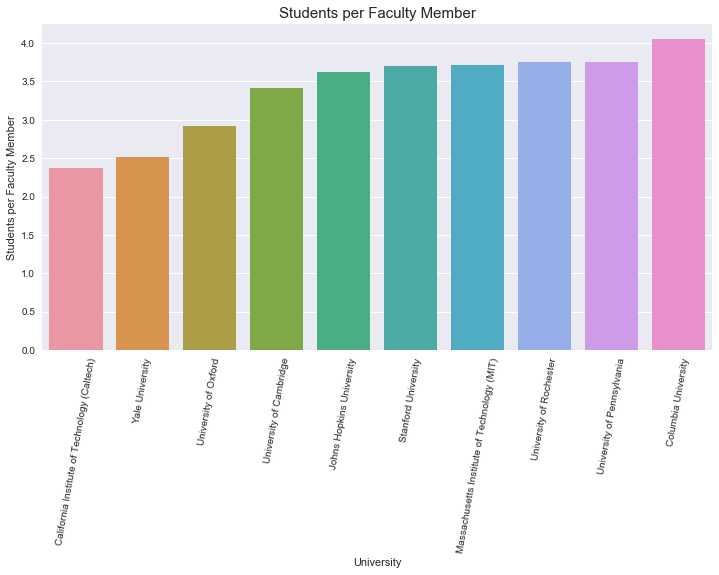

,University,International Student Ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567
198,Maastricht University,0.502533
47,Carnegie Mellon University,0.478062
6,UCL (University College London),0.477928
91,University of St Andrews,0.457955
41,The University of Melbourne,0.427434
126,Queen Mary University of London,0.421816
25,The University of Hong Kong,0.407144


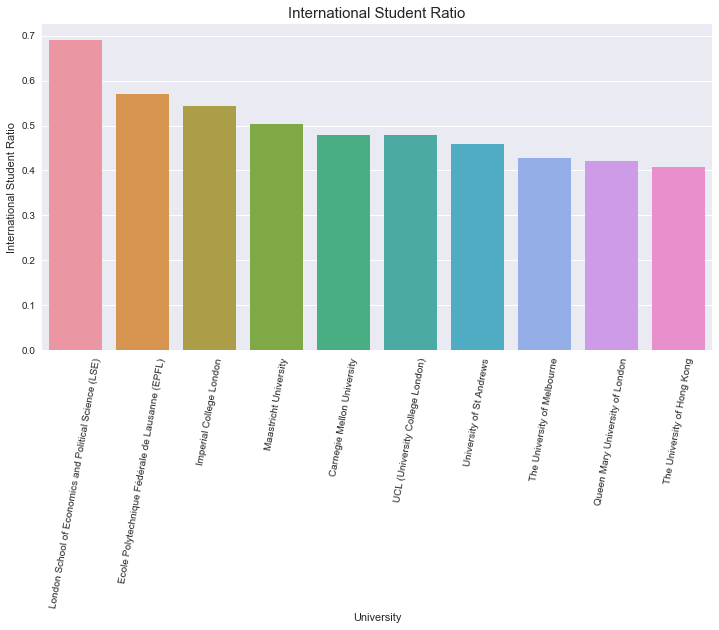

,Students per Faculty Member,std
Country,,
Argentina,7.447841,NaN
Australia,13.625141,2.891384
Austria,19.116949,7.977355
Belgium,14.368971,6.561637
Brazil,12.636989,1.223356
Canada,10.969435,4.916916
Chile,14.584044,3.727604
China,9.043733,2.337943
Denmark,6.603256,4.088438


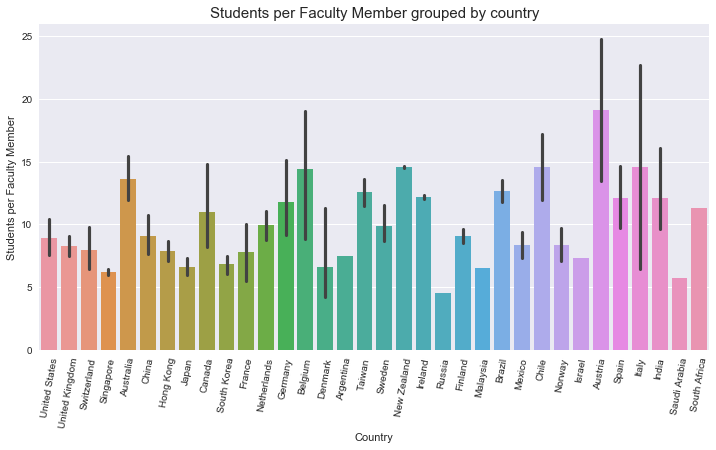

,International Student Ratio,std
Country,,
Argentina,0.221658,NaN
Australia,0.346878,0.056087
Austria,0.306095,0.012236
Belgium,0.160108,0.041895
Brazil,0.034050,0.003259
Canada,0.252604,0.057803
Chile,0.045816,0.012892
China,0.107560,0.047216
Denmark,0.164809,0.063575


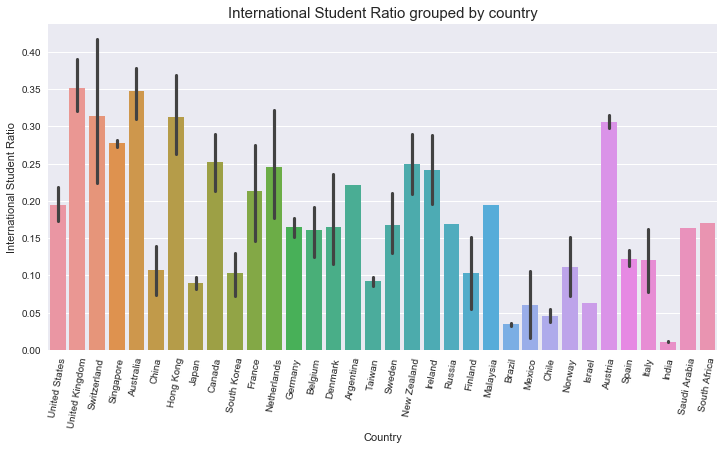

,Students per Faculty Member,std
Region,,
Africa,11.305828,NaN
Asia,7.977623,2.447745
Europe,9.874120,4.311521
Latin America,11.235437,3.525236
North America,9.214235,4.951656
Oceania,13.794974,2.613829


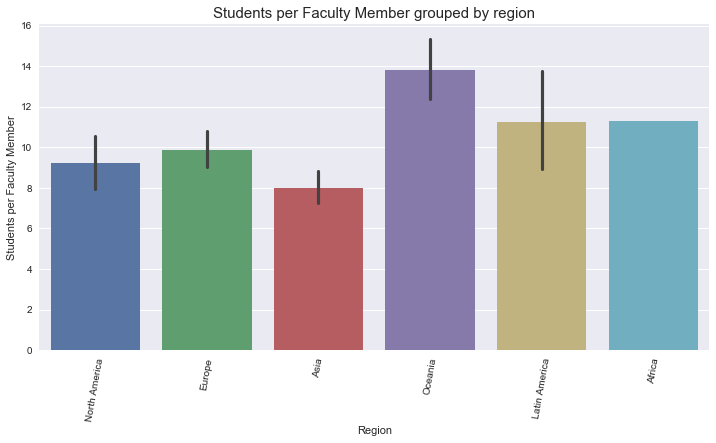

,International Student Ratio,std
Region,,
Africa,0.169703,NaN
Asia,0.132394,0.094492
Europe,0.245932,0.122597
Latin America,0.071751,0.072072
North America,0.202437,0.079258
Oceania,0.329077,0.066382


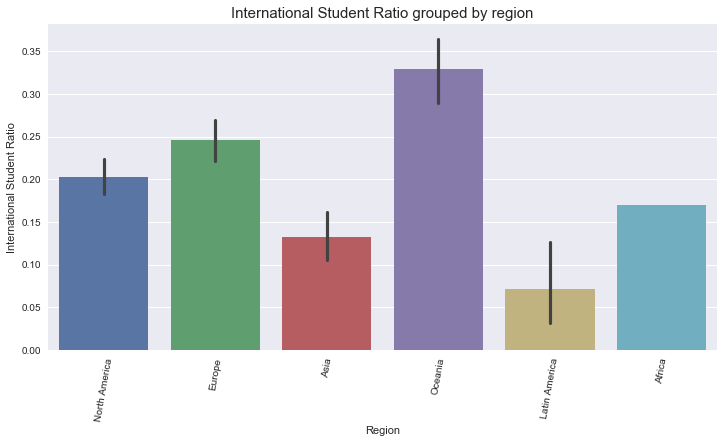

In [80]:
plot_labels = {
    'total_student_count': 'Students per Faculty Member',
    'international_student_count': 'International Student Ratio',
    'country': 'Country',
    'region' : 'Region'
}

def plot_ratio(df, stat, groupby=None):
    # create plot
    fig, ax = plt.subplots()
    
    # calculate ratio
    if stat == 'staff':
        asc = True
        col_name = plot_labels['total_student_count']
        ratio = df['total_student_count'].div(df['total_staff_count'])
    elif stat == 'int':
        asc = False
        col_name = plot_labels['international_student_count']
        ratio = df['international_student_count'].div(df['total_student_count'])


    if groupby is not None:
        title = col_name + " grouped by " + groupby
        
        # create new dataframe
        fsr = pd.concat([df[groupby], ratio], axis=1)
        lbl = plot_labels[groupby]
        fsr.columns = [lbl, col_name]
        fsr_g = fsr.groupby([lbl])[col_name].mean().to_frame()
        fsr_g['std'] = fsr.groupby([lbl])[col_name].std().to_frame()
        #fsr_g.sort_values(by=fsr_g.index, inplace=True, ascending=asc)
        ICD.display(fsr_g)
        sns.barplot(x=lbl, y=col_name, data=fsr, ax=ax)
    else:
        title = col_name
        
        # create new dataframe
        fsr = pd.concat([df.name, ratio], axis=1)
        fsr.columns = ['University', col_name]
        fsr = fsr.sort_values(by=col_name, ascending=asc)[:10]
        ICD.display(fsr)
        sns.barplot(fsr['University'], fsr[col_name], ax=ax)

    ax.set_title(title, fontsize=15)
    plt.rcParams['figure.figsize']=(12,6)
    plt.xticks(rotation=80)
    plt.ylabel(col_name)
    return plt

# tu plots
plot_ratio(tu_df, 'staff').show()
plot_ratio(tu_df, 'int', ).show()
plot_ratio(tu_df, 'staff', 'country').show()
plot_ratio(tu_df, 'int', 'country').show()
plot_ratio(tu_df, 'staff', 'region').show()
plot_ratio(tu_df, 'int', 'region').show()

,University,Students per Faculty Member
105,Vanderbilt University,3.300632
109,University of Copenhagen,4.100229
12,Johns Hopkins University,4.300222
11,Yale University,4.301132
153,University of Rochester,4.301786
97,Emory University,4.401183
16,Duke University,4.500295
114,École Polytechnique,5.107664
183,Scuola Normale Superiore di Pisa,5.202020
185,University of Miami,5.900298


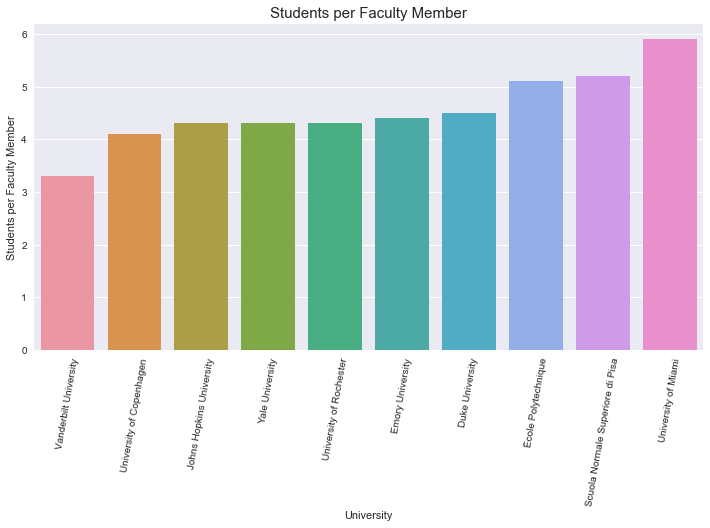

,University,International Student Ratio
24,London School of Economics and Political Science,0.709985
178,University of Luxembourg,0.569934
7,Imperial College London,0.549978
37,École Polytechnique Fédérale de Lausanne,0.549960
102,Maastricht University,0.499970
15,University College London,0.489968
143,University of St Andrews,0.479956
23,Carnegie Mellon University,0.449984
120,Queen Mary University of London,0.449984
39,University of Hong Kong,0.419952


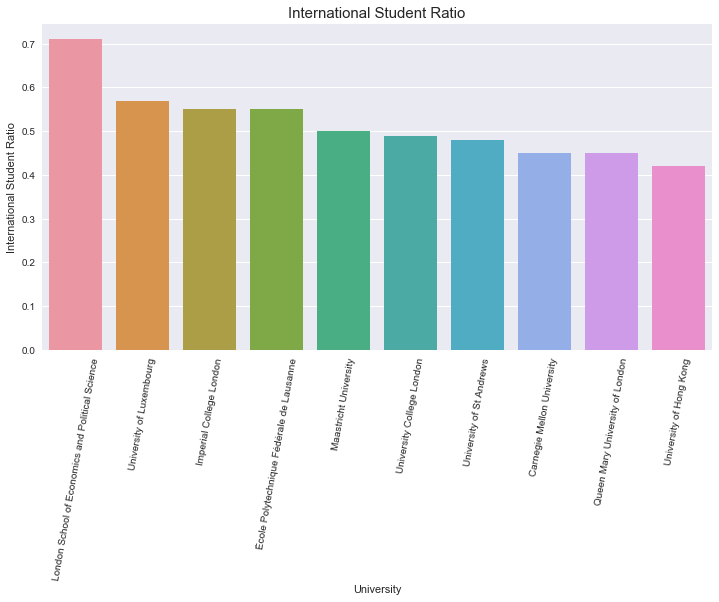

,Students per Faculty Member,std
Country,,
Australia,27.471927,6.414225
Austria,20.808824,NaN
Belgium,38.582896,3.354674
Canada,19.722648,3.951254
China,11.944060,2.461266
Denmark,8.136866,5.427988
Finland,18.219322,2.841508
France,13.459313,8.825202
Germany,44.066533,18.402409


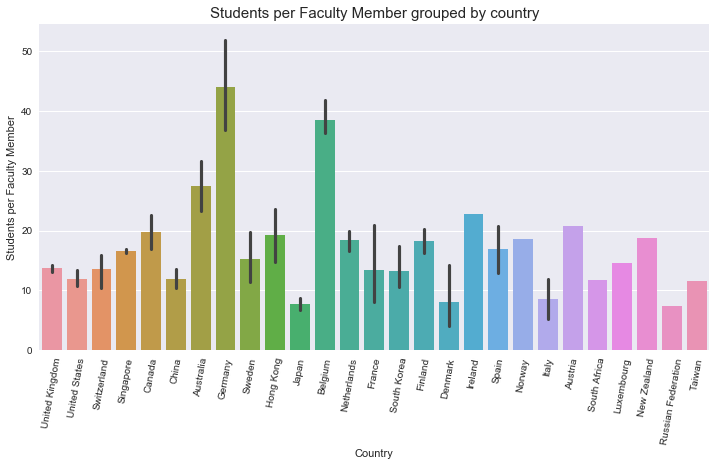

,International Student Ratio,std
Country,,
Australia,0.307481,0.053662
Austria,0.259986,NaN
Belgium,0.197482,0.108138
Canada,0.224984,0.055415
China,0.085695,0.041582
Denmark,0.166643,0.064259
Finland,0.129948,0.098979
France,0.208229,0.085635
Germany,0.151979,0.042000


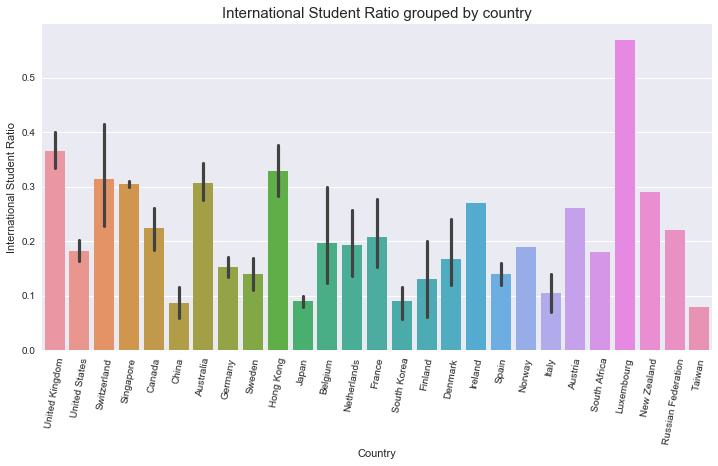

,Students per Faculty Member,std
Region,,
Africa,11.704225,NaN
Asia,13.981138,5.049677
Europe,21.599048,15.267246
North America,12.598345,5.844821
Oceania,26.508710,6.659548
Unknown,10.958202,5.171077


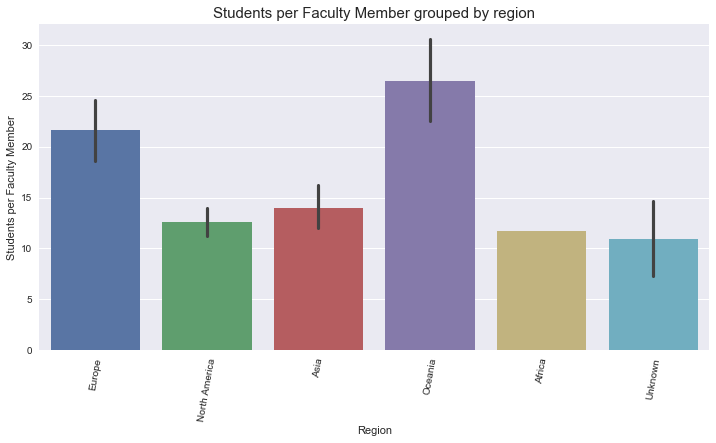

,International Student Ratio,std
Region,,
Africa,0.179976,NaN
Asia,0.165203,0.119831
Europe,0.241576,0.127285
North America,0.185565,0.076041
Oceania,0.305536,0.050534
Unknown,0.394951,0.247463


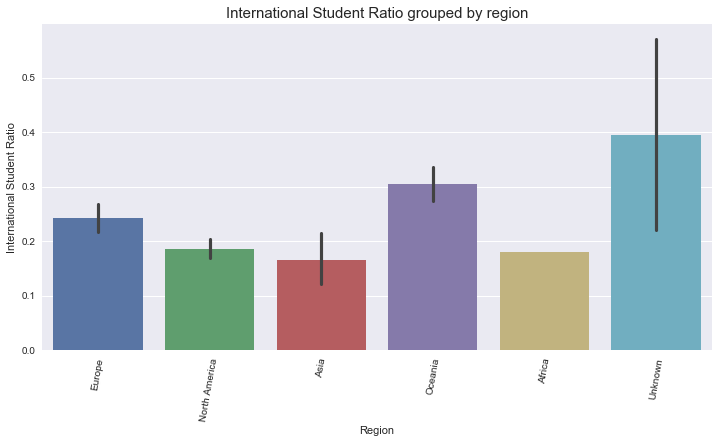

In [81]:
# the plots
plot_ratio(the_df, 'staff').show()
plot_ratio(the_df, 'int', ).show()
plot_ratio(the_df, 'staff', 'country').show()
plot_ratio(the_df, 'int', 'country').show()
plot_ratio(the_df, 'staff', 'region').show()
plot_ratio(the_df, 'int', 'region').show()

#### Matching entries by name
Let us look at the universities that are present in both data sets. Some are present in both rankings, and some are unique to either ranking. We should make sure that each university only occurs once in each dataset to avoid Problems when matching the two sets. 

In [134]:
def duplicate_list(universities):
    """
    Outputs a list of all duplicate entries in provided list
    """
    counts = {}
    for university in universities:
        if university in counts:
            counts[university] += 1
        else:
            counts[university] = 1
    return [k for k, v in counts.items() if v  > 1]

# Show duplicate universities by name
the_duplicates = the_df[the_df['name'].isin(create_count_dict(the_df['name']))]
if the_duplicates.shape[0] > 0:
    ICD.display(the_duplicates)
else:
    print("No duplicates for the_df")
tu_duplicates = tu_df[tu_df['name'].isin(create_count_dict(tu_df['name']))]
if tu_duplicates.shape[0] > 0:
    ICD.display(tu_duplicates)
else:
    print("No duplicates for tu_df")



No duplicates for the_df
No duplicates for tu_df


The names of the universities are unique apart from one exception. To make sure we can match the universities one to one we need to include another variable, in this case we use region in addition to university name to uniquely identify each university.

In [183]:
# University names for both rankings
the_names = set(zip(the_df.name, the_df.region))
assert len(the_names) == the_df.shape[0], \
    "# of university names ({}) does not match # of entries ({})".format(len(the_names), the_df.shape[0])
tu_names = set(zip(tu_df.name, tu_df.region))
assert len(tu_names) == tu_df.shape[0], \
    "# of university names ({}) does not match # of entries ({})".format(len(tu_names), tu_df.shape[0])

# Universities present in both data sets
in_both = the_names.intersection(tu_names)
print("Number of universities in both rankings: {}".format(len(in_both)))

# Universities only present in the_names
only_in_the = the_names.difference(tu_names)
print("Number of universities only in the_names: {}".format(len(only_in_the)))

# Universities only present in tu_names
only_in_tu = tu_names.difference(the_names)
print("Number of universities only in tu_names: {}".format(len(only_in_tu)))

Number of universities in both rankings: 104
Number of universities only in the_names: 96
Number of universities only in tu_names: 96


In [227]:
import difflib, re

def get_word_frequencies(university_names):
    freqs = {}
    for name in university_names:
        for word in name[0].split(' '):
            if word in freqs:
                freqs[word] += 1
            else:
                freqs[word] = 1
    return {k: v for k, v in freqs.items() if v > 8}
    
word_freq_dict = get_word_frequencies(only_in_the.union(only_in_tu))

def clean_string(string):
    string = re.sub(r'[^\x00-\x7f]',r'', str(string[0]))
    for word in word_freq_dict:
        string = string.replace(word, '')
    string = ' '.join(sorted(string.split(' ')))
    return string

def find_matches(word, words):
    lookup = {}
    word = clean_string(word)
    cleaned = set()
    for entry in words:
        temp = clean_string(entry)
        cleaned.add(temp)
        lookup[temp] = entry
    return lookup, difflib.get_close_matches(word, cleaned, n=2, cutoff=0.7)

for word in list(only_in_the):
    lookup, matches = find_matches(word, only_in_tu)
    if matches:
        print(word)
        print(lookup[matches[0]])
        print()

('Karlsruhe Institute of Technology', 'Europe')
('KIT, Karlsruhe Institute of Technology', 'Europe')

('Ohio State University', 'North America')
('The Ohio State University', 'North America')

('University of Massachusetts', 'North America')
('Massachusetts Institute of Technology (MIT)', 'North America')

('University of Edinburgh', 'Europe')
('The University of Edinburgh', 'Europe')

('University of Exeter', 'Europe')
('The University of Exeter', 'Europe')

('École Polytechnique Fédérale de Lausanne', 'Europe')
('Ecole Polytechnique Fédérale de Lausanne (EPFL)', 'Europe')

('École Polytechnique', 'Europe')
('Ecole Polytechnique', 'Europe')

('University of California, Los Angeles', 'North America')
('University of California, Los Angeles (UCLA)', 'North America')

('University of California, Santa Barbara', 'North America')
('University of California, Santa Barbara (UCSB)', 'North America')

('ETH Zurich – Swiss Federal Institute of Technology Zurich', 'Europe')
('ETH Zurich - Swiss 

In [189]:
merged_df = pd.merge(the_df, tu_df, how='inner', on=['name', 'region'], suffixes=('_the', '_tu'))
merged_df

,country_the,international_staff_count_the,international_student_count_the,name,rank_the,region,total_staff_count_the,total_student_count_the,url_the,country_tu,international_staff_count_tu,international_student_count_tu,rank_tu,total_staff_count_tu,total_student_count_tu,url_tu
0,United Kingdom,0,7755,University of Oxford,1,Europe,1822,20409,/world-university-rankings/university-oxford,United Kingdom,2964,7353,6,6750,19720,/universities/university-oxford
1,United Kingdom,0,6436,University of Cambridge,2,Europe,1687,18389,/world-university-rankings/university-cambridge,United Kingdom,2278,6699,5,5490,18770,/universities/university-cambridge
2,United States,0,3485,Stanford University,4,North America,2112,15845,/world-university-rankings/stanford-university,United States,2042,3611,2,4285,15878,/universities/stanford-university
3,United States,0,5284,Harvard University,6,North America,2283,20326,/world-university-rankings/harvard-university,United States,1311,5266,3,4350,22429,/universities/harvard-university
4,United States,0,1909,Princeton University,7,North America,958,7955,/world-university-rankings/princeton-university,United States,246,1793,13,1007,8069,/universities/princeton-university
5,United Kingdom,0,8721,Imperial College London,8,Europe,1390,15857,/world-university-rankings/imperial-college-lo...,United Kingdom,2071,8746,8,3930,16090,/universities/imperial-college-london
6,United States,0,3381,University of Chicago,9,North America,2181,13525,/world-university-rankings/university-chicago,United States,635,3379,9,2449,13557,/universities/university-chicago
7,United States,0,4072,University of Pennsylvania,11,North America,3132,20361,/world-university-rankings/university-pennsylv...,United States,1383,4250,19,5499,20639,/universities/university-pennsylvania
8,United States,0,2552,Yale University,12,North America,2826,12155,/world-university-rankings/yale-university,United States,1708,2469,16,4940,12402,/universities/yale-university
9,United States,0,3719,Johns Hopkins University,13,North America,3604,15498,/world-university-rankings/johns-hopkins-unive...,United States,1061,4105,17,4462,16146,/universities/johns-hopkins-university


In [215]:
col1 = sorted(list(only_in_the), key = lambda tup: tup[0])
col2 = sorted(list(only_in_tu), key = lambda tup: tup[0])
pd.DataFrame.from_items([('the', col1) , ('tu', col2)])

,the,tu
0,"(Arizona State University, North America)","(Albert-Ludwigs-Universitaet Freiburg, Europe)"
1,"(Australian National University, Oceania)","(Alma Mater Studiorum - University of Bologna,..."
2,"(Autonomous University of Barcelona, Europe)","(California Institute of Technology (Caltech),..."
3,"(California Institute of Technology, North Ame...","(CentraleSupélec, Europe)"
4,"(Case Western Reserve University, North America)","(Chalmers University of Technology, Europe)"
5,"(Charité - Universitätsmedizin Berlin, Europe)",(ETH Zurich - Swiss Federal Institute of Techn...
6,"(Chinese University of Hong Kong, Asia)","(Eberhard Karls Universität Tübingen, Europe)"
7,(ETH Zurich – Swiss Federal Institute of Techn...,"(Ecole Polytechnique, Europe)"
8,"(Free University of Berlin, Europe)",(Ecole Polytechnique Fédérale de Lausanne (EPF...
9,"(Georgetown University, North America)","(Ecole normale supérieure, Paris, Europe)"
